In [1]:
import json
import os
import shutil
import warnings

In [2]:
import gensim
import gensim.parsing.preprocessing as gsp
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
from gensim import corpora
from gensim.models import CoherenceModel
from nltk import WordNetLemmatizer, PorterStemmer
from pandas import DataFrame
from tqdm import tqdm
from IPython.core.display import HTML
import matplotlib.ticker as ticker

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

MISC CONFIGURATION

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

COHERENCE METRIC USED FOR HYPERPARAMETER OPTIMIZATION.

In [5]:
COHERENCE_METRIC = "u_mass"

PATHS

In [6]:
CACHED_QUESTIONS_FILE = 'cached_questions.json'
MODELS_PATH = 'models/unsupervised'
VISUALISATIONS_PATH = 'lda_topics_visualisations'

NLTK PACKAGES

In [7]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/xavier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/xavier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

NLTK OBJECTS

In [8]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [9]:
def remove_last_generated_models():
    """Removes the content of the saved models and visualisations."""
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH)
    shutil.rmtree(VISUALISATIONS_PATH, ignore_errors=True)
    os.makedirs(VISUALISATIONS_PATH)

In [10]:
def load_cached_questions():
    """Load questions from the cache file."""
    with open(CACHED_QUESTIONS_FILE, 'r', encoding='utf-8') as f:
        return json.load(f)

In [11]:
def extract_and_clean_text(question: dict):
    """Create a new 'text' field for each question containing the cleaned, tokenized and lemmatized title + body."""
    title = question['title']
    body = question['body']
    text = f"{title} {body}"
    
    for filter in [gsp.strip_tags,
                   gsp.strip_punctuation,
                   gsp.strip_multiple_whitespaces,
                   gsp.strip_numeric,
                   gsp.remove_stopwords,
                   gsp.strip_short,
                   gsp.lower_to_unicode]:
        text = filter(text)
        
    cleaned_text = text.replace("quot", "")
    tokenized_text = nltk.tokenize.word_tokenize(cleaned_text)

    # words_stemmed = (stemmer.stem(w) for w in words_without_short_words)
    words_lemmatized = [lemmatizer.lemmatize(w) for w in tokenized_text]
    question['text'] = " ".join(words_lemmatized)

    # bigrams = nltk.bigrams(tokenized_text)
    # question['bigrams'] = [' '.join(bigram) for bigram in bigrams]

    # trigrams = nltk.trigrams(tokenized_text)
    # question['trigrams'] = [' '.join(trigram) for trigram in trigrams]
    return question

In [12]:
def compute_coherence_values_of_lda_model(corpus, id2word, texts, num_topics, alpha, eta):
    """Train a model and compute its coherence value."""
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           passes=10,
                                           alpha=alpha,
                                           eta=eta)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence=COHERENCE_METRIC)
    
    return coherence_model_lda.get_coherence()

In [13]:
def get_results_of_hyperoptimisation(corpus, id2word, texts):
    """Returns the best hyperparameters for the LDA model based on the coherence metric."""
    topics_range = range(2, 17, 1)

    alphas = list(np.arange(0.01, 2, 0.3))
    alphas.append('symmetric')
    alphas.append('asymmetric')

    etas = list(np.arange(0.01, 1, 0.3))
    etas.append('symmetric')
    etas.append(None)

    model_results = []

    # OVERRIDES for test
    # topics_range = [2, 3, 4]
    # alphas = ['symmetric']
    # etas = [None]

    pbar = tqdm(total=(len(etas) * len(alphas) * len(topics_range)))
    for num_topics in topics_range:
        for alpha in alphas:
            for eta in etas:
                cv = compute_coherence_values_of_lda_model(corpus, id2word, texts, num_topics, alpha, eta)

                model_results.append({"num_topics": num_topics, "alpha": alpha, "eta": eta, "cv": cv})
                pbar.update(1)

    pbar.close()

    return model_results

In [14]:
def create_coherence_metrics_plot(results):
    """Displays a plot showing the best coherence metric value per number of topics."""
    results_df = DataFrame(results)[["cv", "num_topics"]]
    
    fig = plt.subplots(figsize=(15, 8))
    performance_plot = sns.lineplot(x='num_topics', y='cv', data=results_df)
    performance_plot.set_xticks(range(2, results_df['num_topics'].max() + 1)) 
    performance_plot.set_title("Best coherence metric per topics number")
    performance_plot.title.set_size(20)
    
    plt.show()
    plt.close()

In [15]:
def visualize_lda_topics(corpus, id2word, lda_model, num_topics):
    """Visualize the topics of the LDA model."""
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    
    # Workaround as pyLDAvis.display() doesn't work, even after pyLDAvis.enable_notebook(local=True)
    visualisations_path = f"{VISUALISATIONS_PATH}/{num_topics}_topics"
    os.makedirs(visualisations_path, exist_ok=True)
    pyLDAvis.save_html(LDAvis_prepared, f'{visualisations_path}/lda_results.html')
    display(HTML(f'{visualisations_path}/lda_results.html'))


In [16]:
def save_model(best_hyperparameters, lda_model):
    """Save the LDA model"""
    lda_model.save(f"{MODELS_PATH}/lda_model_with_{best_hyperparameters['num_topics']}_topics.model")

In [17]:
def train_lda_models(questions):
    """Find the best hyperparameters for LDA models with different topics numbers and visualizes their LDA topics and saves their model."""
    print("Starting the search of the best hyperparameters of the LDA model.\n")
    texts = [question['text'].split(" ") for question in questions]

    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]

    model_results = get_results_of_hyperoptimisation(corpus, id2word, texts)

    create_coherence_metrics_plot(model_results)

    for num_topics in [result['num_topics'] for result in model_results]:
        print(f"Displaying results for the number of topics:{num_topics}.\n")

        results = [result for result in model_results if result['num_topics'] == num_topics][0]
        print(f"Best hyperparameters found:{results}.\n")

        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics,
                                               passes=10,
                                               alpha=results['alpha'],
                                               eta=results['eta'])

        visualize_lda_topics(corpus, id2word, lda_model, num_topics)
        # Disabled in this notebook
        # save_model(num_topics, lda_model)

Starting unsupervised learning script.

100 questions loaded from cache.

Texts extracted and cleaned.

Starting the search of the best hyperparameters of the LDA model.



100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


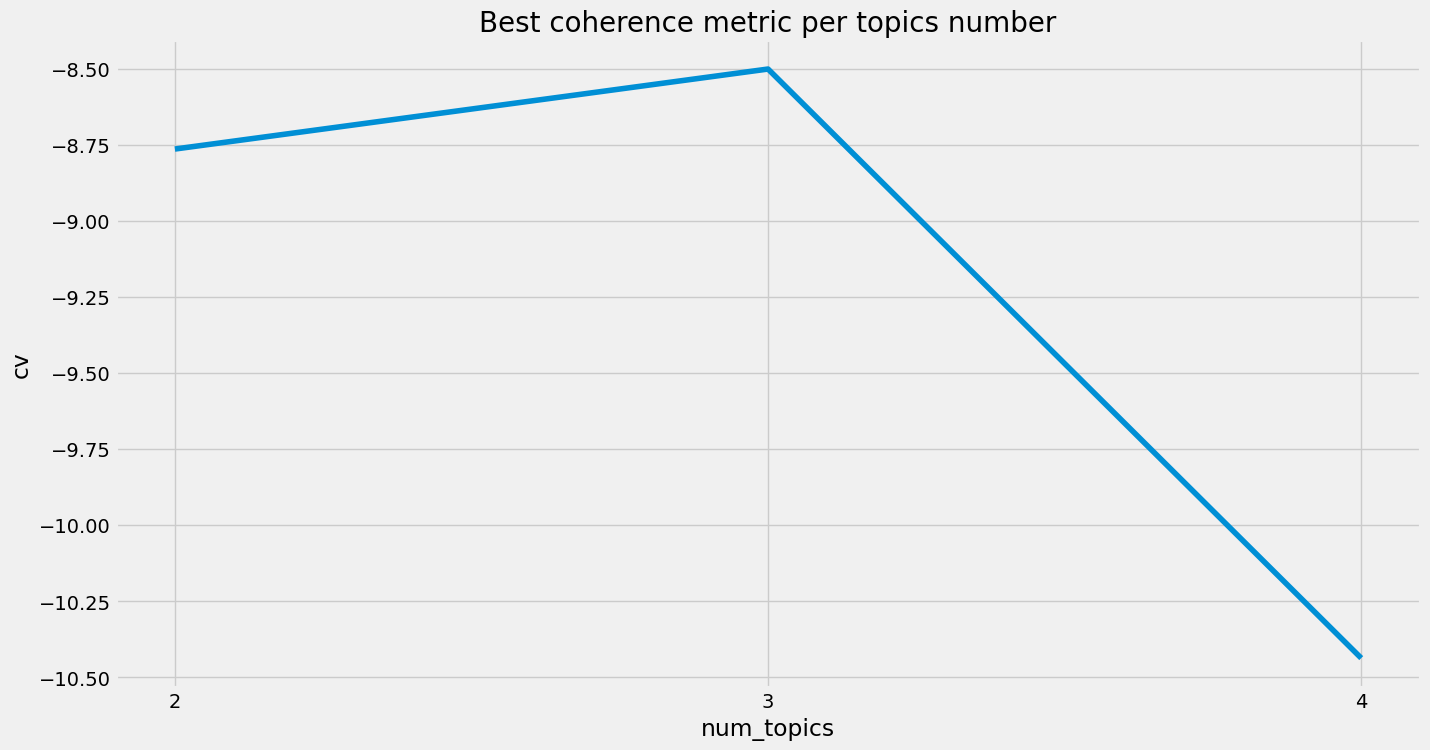

Displaying results for the number of topics:2.

Best hyperparameters found:{'num_topics': 2, 'alpha': 'symmetric', 'eta': None, 'cv': -8.762686051155441}.



Displaying results for the number of topics:3.

Best hyperparameters found:{'num_topics': 3, 'alpha': 'symmetric', 'eta': None, 'cv': -8.499555833474666}.



Displaying results for the number of topics:4.

Best hyperparameters found:{'num_topics': 4, 'alpha': 'symmetric', 'eta': None, 'cv': -10.437039991081637}.




Unsupervised learning script finished.


In [18]:
print("Starting unsupervised learning script.\n")
remove_last_generated_models()

json_questions = load_cached_questions()

questions = [{
    "body": question['body'],
    "tags": question['tags'],
    "title": question['title']
} for question in json_questions]
print(f"{len(questions)} questions loaded from cache.\n")

questions = list(map(extract_and_clean_text, questions))
print("Texts extracted and cleaned.\n")

train_lda_models(questions)

print("\nUnsupervised learning script finished.")